In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import datetime
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from sklearn import metrics
from sklearn.utils import shuffle
from skimage import draw
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from skimage.util import pad
import skimage
import time
import math

from tqdm import tqdm_notebook as tqdm 

from Dataset.Dataset import DataSet,Scale,ToTensor,RandomGaussionBlur,RandomMedianBlur\
,RandomHorizontalFlip,RandomRotation,visualize_loader

import warnings
warnings.filterwarnings('ignore')

from Models import DualEncoding_U_Net, save_model,load_model,init_weights,DualEncodingDecoding_U_Net,\
DualEncoding_U_Net_without_asm,AttnUNet
from Metrics import SoftDiceLoss,dice_metric,MultiClassBCE,SoftDiceLoss,DE_loss
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
    
import pickle



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:

h_e_train_patch_dir='Data/CoNSeP/{}/H_E_patches'.format('Train')
h_train_patch_dir='Data/CoNSeP/{}/H_patches'.format('Train')

nuclei_mask_train_patch_dir='Data/CoNSeP/{}/nuclei_patches'.format('Train')
boundary_mask_train_patch_dir='Data/CoNSeP/{}/boundary_patches'.format('Train')

h_e_test_patch_dir='Data/CoNSeP/{}/H_E_patches'.format('Test')
h_test_patch_dir='Data/CoNSeP/{}/H_patches'.format('Test')

nuclei_mask_test_patch_dir='Data/CoNSeP/{}/nuclei_patches'.format('Test')
boundary_mask_test_patch_dir='Data/CoNSeP/{}/boundary_patches'.format('Test')

194
129
MAX VALUE :  
H&E 1.0 
H 1.0 
nuclei_mask 1.0 
boundary_mask 1.0


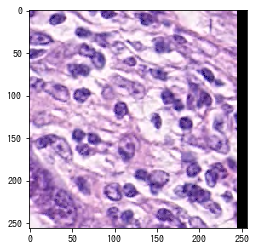

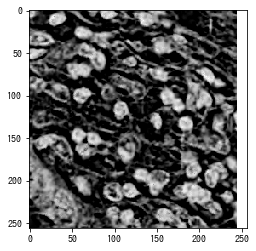

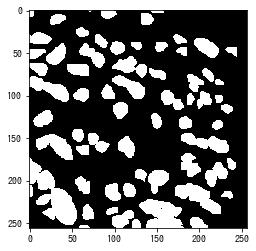

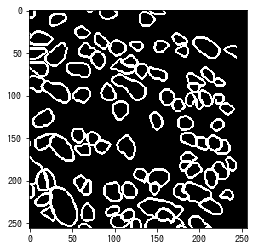

In [3]:
batch_size_train=4
batch_size_test=4
                                                
train_transform=torchvision.transforms.Compose([RandomGaussionBlur(p=0.4,sigma=0.5,truncate=4,apply_dual=False),\
                                                RandomMedianBlur(p=0.4,disk_rad=1),\
                                                RandomHorizontalFlip(p=0.4),\
                                                RandomRotation( degrees=[60,120],p=0.38),\
                                                Scale(),\
                                                ToTensor()])
test_transform=torchvision.transforms.Compose([Scale(),ToTensor()])
train_dataset=DataSet(h_e_train_patch_dir,h_train_patch_dir\
                      ,nuclei_mask_train_patch_dir, boundary_mask_train_patch_dir\
                      ,transform=train_transform,attn_gray=True)
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_dataset=DataSet(h_e_test_patch_dir,h_test_patch_dir\
                      ,nuclei_mask_test_patch_dir, boundary_mask_test_patch_dir\
                      ,transform=test_transform,attn_gray=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=False)

print(train_loader.__len__())
print(test_loader.__len__())
visualize_loader(test_loader,0)

In [7]:
model=DualEncoding_U_Net(img1_ch=3,img2_ch=1,output_ch=2,dropout=0.25,include_ffm=False)
# model=DualEncodingDecoding_U_Net(img_ch1=3,img_ch2=1,output_ch1=1,output_ch2=1,dropout=0.45)
# model=AttnUNet(img_ch=3,output_ch=2,dropout=0.5)
# model=DualEncoding_U_Net_without_asm(img1_ch=3,img2_ch=1,output_ch=2,dropout=0.4)

model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'Trained_models/model_CoNSep_final_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('{} dir has been made'.format(BEST_MODEL_PATH))
print("Model's state_dict:")
writer = SummaryWriter('{}/experiment_{}'.format(BEST_MODEL_PATH,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/datalab/training-assets/R_medical/atheeth/nuclei_seg/Trained_models/model_CoNSep_final_2020_03_15 dir has been made
Model's state_dict:
Conv1_encoding_1.conv.0.weight 	 torch.Size([64, 3, 3, 3])
Conv1_encoding_1.conv.0.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.weight 	 torch.Size([64])
Conv1_encoding_1.conv.1.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1_encoding_1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1_encoding_1.conv.3.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.weight 	 torch.Size([64])
Conv1_encoding_1.conv.4.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2_encoding_1.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2_encoding_1.conv.0.bias 	 torch.Size([128]

In [8]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
pretrained=False
optimizer_selected='adam'
scheduler_type='reduce_on_plateau'
batchsize=batch_size_train
no_steps=train_dataset.__len__()//batchsize
restart_epochs=8
num_epochs=80
predict_boundary=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#criterion = SoftDiceLoss()#
criterion=nn.BCELoss()
# criterion=MultiClassBCE(weights=[0.11,0.89])
# criterion=DE_loss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)

if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-03, betas=(0.9, 0.98))#,weight_decay=0.02)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)


if scheduler_type=='reduce_on_plateau':
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6,\
                                               verbose=True, threshold=0.0001, threshold_mode='rel',\
                                               cooldown=2, min_lr=10e-06, eps=1e-08)
    
else:
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)

if pretrained:
    filename='model_CPM_17_v2_2020_02_07/model_optim.pth'
    load_model(filename,model,optimizer=None,scheduler=None)
else:
    init_weights(model)

best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                
                # get the inputs; data is a list of [dapi, nuclei, boundary]
                if predict_boundary:
                    h_e_train, h_train,nuclei_mask_train,boundary_mask_train = sample_batched['h_e']\
                    ,sample_batched['h']\
                    ,sample_batched['nuclei_mask']\
                    ,sample_batched['boundary_mask']
                    
                    h_e_train, h_train,nuclei_mask_train,boundary_mask_train = \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)\
                    ,boundary_mask_train.to(device, dtype = torch.float)
                    
                    gt_mask_train=torch.cat((nuclei_mask_train,boundary_mask_train),dim=1)
                
                else:
                    h_e_train, h_train,nuclei_mask_train= sample_batched['h_e']\
                    ,sample_batched['h']\
                    ,sample_batched['nuclei_mask']\

                    h_e_train, h_train,nuclei_mask_train= \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)
                    
                    gt_mask_train=nuclei_mask_train

                # forward + backward + optimize
#                 img_batch_comb=torch.cat((img_batch,dapi_batch),dim=1)
                outputs,attn_maps_train = model(h_e_train,h_train)
                outputs=torch.sigmoid(outputs)
    
                if predict_boundary:
                    pred_nuclei_train,pred_boundary_train=torch.chunk(outputs,2,dim=1)
                else:
                    pred_nuclei_train=outputs
                

                
                loss = criterion(outputs, gt_mask_train)
                dice_score=dice_metric(pred_nuclei_train,nuclei_mask_train)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if (i+1)%50==0:
                    
                    if predict_boundary:
                        img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu(),\
                                             pred_boundary_train.detach().cpu(),boundary_mask_train.detach().cpu()),dim=0)
                    else:
                        img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu()),dim=0)
                    
                    img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=10)
                    torchvision.utils.save_image\
                    (img_grid2,os.path.join(BEST_MODEL_PATH,\
                                            'train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                    
                    for x,attn_map in enumerate(attn_maps_train):
                        attn_maps_train[x]=attn_maps_train[x].detach().cpu()
                        current_shape=list(attn_maps_train[x].shape)
                        final_shape=list(attn_maps_train[0].shape)
                        
                        
                        if x!=0:
                            pad_shape=((final_shape[-2]-current_shape[-2])//2,\
                                       final_shape[-2]-current_shape[-2]-(final_shape[-2]-current_shape[-2])//2,\
                                      (final_shape[-1]-current_shape[-1])//2,\
                                       final_shape[-2]-current_shape[-2]-(final_shape[-1]-current_shape[-1])//2)
                            attn_maps_train[x]=F.pad(attn_maps_train[x],pad_shape,"constant", 0)
                       
                        
                        
                    img_tensor_attn=torch.cat(tuple(attn_maps_train),dim=0)
                    img_grid_attn = torchvision.utils.make_grid(img_tensor_attn\
                                                                ,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid_attn,os.path.join(BEST_MODEL_PATH,\
                                            'attn_train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                if scheduler_type!='reduce_on_plateau':
                    scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
                
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
            
            writer.add_scalar('Train dice { epoch }',
                            run_avg_train_dice,
                            epoch+1)
                
            writer.add_scalar('Train loss { epoch }',
                    run_avg_train_loss,
                    epoch * len(train_loader) + epoch+1)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):
                
                
                if predict_boundary:
                    h_e_test, h_test,nuclei_mask_test,boundary_mask_test = test_sample['h_e']\
                    ,test_sample['h']\
                    ,test_sample['nuclei_mask']\
                    ,test_sample['boundary_mask']
                    
                    h_e_test, h_test,nuclei_mask_test,boundary_mask_test = \
                    h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                    ,nuclei_mask_test.to(device, dtype = torch.float)\
                    ,boundary_mask_test.to(device, dtype = torch.float)
                    
                    gt_mask_test=torch.cat((nuclei_mask_test,boundary_mask_test),dim=1)
                    
                else:
                
                    h_e_test, h_test,nuclei_mask_test= test_sample['h_e']\
                    ,test_sample['h']\
                    ,test_sample['nuclei_mask']

                    h_e_test, h_test,nuclei_mask_test = \
                    h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                    ,nuclei_mask_test.to(device, dtype = torch.float)

                    gt_mask_test=nuclei_mask_test
    
                test_outputs,attn_maps_test = model(h_e_test,h_test)
                test_outputs=torch.sigmoid(test_outputs)
        
        
                if predict_boundary:
                    pred_nuclei_test,pred_boundary_test=torch.chunk(test_outputs,2,dim=1)
                else:
                    pred_nuclei_test=test_outputs
    
                test_loss = criterion(test_outputs, gt_mask_test)
                test_dice=dice_metric(pred_nuclei_test,nuclei_mask_test)
                
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
                
               
                if (j+1)%50==0:
                    if predict_boundary:
                        img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu(),\
                                                  pred_boundary_test.detach().cpu(),boundary_mask_test.detach().cpu()),dim=0)
                    else:
                        img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu()),dim=0)
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid,os.path.join(BEST_MODEL_PATH,\
                                            'test_iter_{}.png'.format(epoch*len(test_loader)+j+1)))
                    for x,attn_map in enumerate(attn_maps_test):
                        attn_maps_test[x]=attn_maps_test[x].detach().cpu()
#                         print(list(attn_maps[0].shape))
                        current_shape=list(attn_maps_test[x].shape)
                        final_shape=list(attn_maps_test[0].shape)
                        if x!=0:
                            pad_shape=((final_shape[-2]-current_shape[-2])//2,\
                                       final_shape[-2]-current_shape[-2]-(final_shape[-2]-current_shape[-2])//2,\
                                      (final_shape[-1]-current_shape[-1])//2,\
                                       final_shape[-2]-current_shape[-2]-(final_shape[-1]-current_shape[-1])//2)
                            attn_maps_test[x]=F.pad(attn_maps_test[x],pad_shape,"constant", 0)
                            
                        
                    img_tensor_attn_test=torch.cat(tuple(attn_maps_test),dim=0)
                    img_grid_attn_test = torchvision.utils.make_grid(img_tensor_attn_test\
                                                                ,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid_attn_test,os.path.join(BEST_MODEL_PATH,\
                                            'attn_test_iter_{}.png'.format(epoch*len(train_loader)+j+1)))
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            
            writer.add_scalar('Test dice { epoch }',
                            run_avg_test_dice,
                            epoch+1)
                
            writer.add_scalar('Test loss { epoch }',
                    run_avg_test_loss,
                    epoch * len(train_loader) + epoch+1)
            
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+\
                           '/model_optim.pth',scheduler=scheduler)
                print("saved model with test dice score: {}".format(best_val))
            if scheduler_type=='reduce_on_plateau':
                scheduler.step(run_avg_test_loss)
    
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    

with open("{}/history.txt".format(BEST_MODEL_PATH), "wb") as fp:   #Pickling
    pickle.dump(history, fp)

Tesla V100-SXM2-32GB
initialized network with normal initialization
Learning Rate : 0.001


test_loss: 0.2612983012050575
test_dice :0.6790799616592633
saved model with test dice score: 0.6790799616592633
Learning Rate : 0.001


test_loss: 0.24780615671111486
test_dice :0.6581019921690635
Learning Rate : 0.001


test_loss: 0.25375708920262413
test_dice :0.6907900774823236
saved model with test dice score: 0.6907900774823236
Learning Rate : 0.001


test_loss: 0.2228420950367984
test_dice :0.6980605681105395
saved model with test dice score: 0.6980605681105395
Learning Rate : 0.001


test_loss: 0.242510972505544
test_dice :0.6658953294059826
Learning Rate : 0.001


test_loss: 0.21834343842278506
test_dice :0.7305531889427539
saved model with test dice score: 0.7305531889427539
Learning Rate : 0.001


test_loss: 0.21521042372605978
test_dice :0.7352491693936216
saved model with test dice score: 0.7352491693936216
Learning Rate : 0.001


test_loss: 0.20928294946599604
test_dice :0.7202799564869807
Learning Rate : 0.001


test_loss: 0.20562285937276084
test_dice :0.726796748312927
Learning Rate : 0.001


test_loss: 0.22308070483495188
test_dice :0.7288183251436054
Learning Rate : 0.001


test_loss: 0.20372061885574388
test_dice :0.7426731463856416
saved model with test dice score: 0.7426731463856416
Learning Rate : 0.001


test_loss: 0.21737355894944396
test_dice :0.7152805187935365
Learning Rate : 0.001


test_loss: 0.2032495563350966
test_dice :0.737078607968961
Learning Rate : 0.001


test_loss: 0.20625937848768902
test_dice :0.7596892520146215
saved model with test dice score: 0.7596892520146215
Learning Rate : 0.001


test_loss: 0.2073749107218339
test_dice :0.7428659680159124
Learning Rate : 0.001


test_loss: 0.20266796908964707
test_dice :0.7565179674975152
Learning Rate : 0.001


test_loss: 0.20502755642290926
test_dice :0.7401187769677965
Learning Rate : 0.001


test_loss: 0.20946983557081902
test_dice :0.7597952565165327
saved model with test dice score: 0.7597952565165327
Learning Rate : 0.001


test_loss: 0.20999938688374833
test_dice :0.7471265504964922
Learning Rate : 0.001


test_loss: 0.20116138258724245
test_dice :0.7685169439493751
saved model with test dice score: 0.7685169439493751
Learning Rate : 0.001


test_loss: 0.20995923914864412
test_dice :0.7486465274928523
Learning Rate : 0.001


test_loss: 0.20516504664022422
test_dice :0.7615985145100088
Learning Rate : 0.001


test_loss: 0.21091270169117696
test_dice :0.7685207788565674
saved model with test dice score: 0.7685207788565674
Learning Rate : 0.001


test_loss: 0.20358336525498477
test_dice :0.7707942953948388
saved model with test dice score: 0.7707942953948388
Learning Rate : 0.001


test_loss: 0.22415115888589285
test_dice :0.7595793651985808
Learning Rate : 0.001


test_loss: 0.2114524286300894
test_dice :0.753971090539536
Learning Rate : 0.001


test_loss: 0.2102161269870047
test_dice :0.7787485746216625
saved model with test dice score: 0.7787485746216625
Epoch    27: reducing learning rate of group 0 to 1.0000e-04.
Learning Rate : 0.0001


test_loss: 0.20400848094495222
test_dice :0.7802681798117773
saved model with test dice score: 0.7802681798117773
Learning Rate : 0.0001


test_loss: 0.20236242486313824
test_dice :0.7812807901893952
saved model with test dice score: 0.7812807901893952
Learning Rate : 0.0001


test_loss: 0.20181372447869064
test_dice :0.782809452292258
saved model with test dice score: 0.782809452292258
Learning Rate : 0.0001


test_loss: 0.2049353490058858
test_dice :0.7813778485509949
Learning Rate : 0.0001


test_loss: 0.2079895678384061
test_dice :0.7737643573443767
Learning Rate : 0.0001


test_loss: 0.20754014529860337
test_dice :0.7813646205269322
Learning Rate : 0.0001


test_loss: 0.2082957765708943
test_dice :0.7834638764781273
saved model with test dice score: 0.7834638764781273
Learning Rate : 0.0001


test_loss: 0.20847605952425988
test_dice :0.7830048854363375
Learning Rate : 0.0001


test_loss: 0.21566482932856934
test_dice :0.7751289605904318
Epoch    36: reducing learning rate of group 0 to 1.0000e-05.
Learning Rate : 1e-05


test_loss: 0.2076763568362469
test_dice :0.7803102149201829
Learning Rate : 1e-05


test_loss: 0.2076663986666404
test_dice :0.782603513782361
Learning Rate : 1e-05


test_loss: 0.20989491081611902
test_dice :0.7799342907220275
Learning Rate : 1e-05


test_loss: 0.2087282807921781
test_dice :0.7832642853227088
Learning Rate : 1e-05


test_loss: 0.20963631658441415
test_dice :0.783721771529126
saved model with test dice score: 0.783721771529126
Learning Rate : 1e-05


test_loss: 0.2085887964355038
test_dice :0.7822119420443545
Learning Rate : 1e-05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



test_loss: 0.21176344894020427
test_dice :0.7840572822107069
Learning Rate : 1e-05


test_loss: 0.21042968106781837
test_dice :0.7835648372651998
Learning Rate : 1e-05


test_loss: 0.20982601169383008
test_dice :0.7817660810006579
Learning Rate : 1e-05


test_loss: 0.2107181465530974
test_dice :0.7851635042368682
Learning Rate : 1e-05


test_loss: 0.20978116219203602
test_dice :0.7850806123612105
Learning Rate : 1e-05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



test_loss: 0.21005307073650617
test_dice :0.7845791605963484


In [ ]:
# features = list(model(h_e_train,h_train).features)
# print(len(features))

# self.features = nn.ModuleList(features).eval() 

In [ ]:
# !mv model_2020_02_03 model_2020_02_03_old

In [ ]:
# os.system("python test_model.py")
# save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    


In [6]:
# os.system('rm -rf {}'.format(BEST_MODEL_PATH))

0